Welcome to Argoverse! We'll show some quick ways to get started with the Argoverse maps:

Note that to run this tutorial, you'll need to install the `mayavi` python package. See the instruction on how to install it [here](https://docs.enthought.com/mayavi/mayavi/installation.html)

# Map API

To access our map API, simply create an `ArgoverseMap`

In [13]:
tracking_dataset_dir = '../argoverse-tracking/sample/'

from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap()

## Lane Polygon

`ArgoverseMap.find_local_lane_polygons` can be used to retrieve polygon of lanes in the specified area. 

As an example, we will get a city coordinate of the car from log 0, frame 10, and show the first 5 lane polygons within 60 meters around the cars.

In [14]:
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

log_index = 0
frame_index = 100
idx = 100
argoverse_loader = ArgoverseTrackingLoader(tracking_dataset_dir)
log_id = argoverse_loader.log_list[log_index]
argoverse_data = argoverse_loader[log_index]
city_name = argoverse_data.city_name

lidar_pts = argoverse_data.get_lidar(idx)

In [15]:
"""
The coordinate used in `ArgoverseMap` is a city coordinate, while the 
annotation in `Argoverse-Tracking` dataset is in egovehicle coordinate. 

These `egovehicle` can be converted to city coodinate using pose information 
available in the dataset. 
"""
x,y,_ = argoverse_data.get_pose(frame_index).translation

---------------------------------------------
------Example of getting lane polygon--------
---------------------------------------------


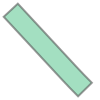

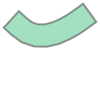

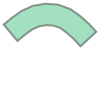

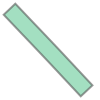

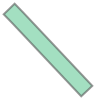

In [16]:
from shapely.geometry.polygon import Polygon
print('---------------------------------------------')
print('------Example of getting lane polygon--------')
print('---------------------------------------------')
for i in range(5):
    #Use the corresponding city name with log id
    display(Polygon(am.find_local_lane_polygons([x-30, x+30, y-30, y+30], 'PIT')[i])) 

## Driveable Area

Driveable area can also be queried in the same way,

--------------------------------------------------------
------Example of getting region of driveable area--------
--------------------------------------------------------


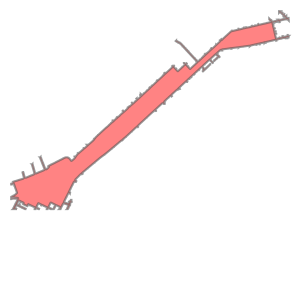

In [25]:
print('--------------------------------------------------------')
print('------Example of getting region of driveable area--------')
print('--------------------------------------------------------')
offset = 0
display(Polygon(am.find_local_driveable_areas([x-offset, x+offset, y-offset, y+offset], 'PIT')[0]))

# Visualize data on the map

Here we will visualize data from `Argoverse-Tracking` dataset on top of our map information. 

In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from visualize_30hz_benchmark_data_on_map import DatasetOnMapVisualizer

# Map from a bird's-eye-view (BEV)
dataset_dir = tracking_dataset_dir
experiment_prefix = 'visualization_demo'

#if you are running for the first time, or using a new set of logs, this will need to be set False to accumelate the labels again
use_existing_files = False


import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

domv = DatasetOnMapVisualizer(dataset_dir, experiment_prefix, use_existing_files=use_existing_files, log_id=argoverse_data.current_log)


One example is to overlay our label annotations on top of our map information. Here the pink area denotes the `driveable area`

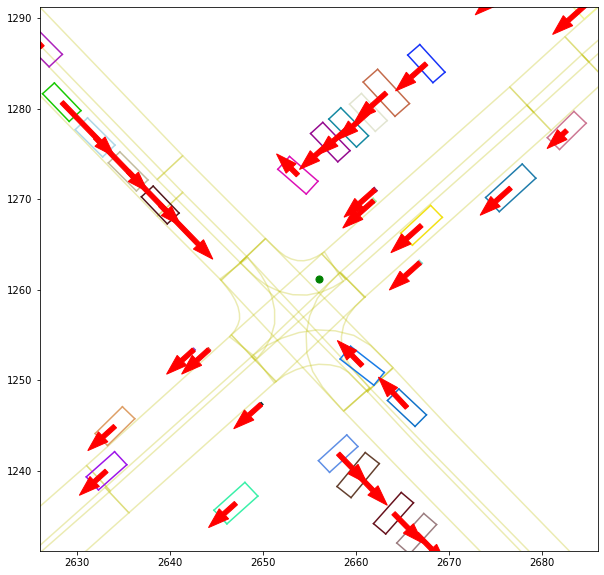

In [59]:
import copy

idx = 10

city_to_egovehicle_se3 = argoverse_data.get_pose(idx)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
xcenter,ycenter,_ = argoverse_data.get_pose(idx).translation

offset = 30
xmin = xcenter - offset  # 150
xmax = xcenter + offset  # 150
ymin = ycenter - offset  # 150
ymax = ycenter + offset  # 150
ax.scatter(xcenter, ycenter, 200, color="g", marker=".", zorder=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
local_das = am.find_local_driveable_areas([xmin, xmax, ymin, ymax], city_name)

domv.render_bev_labels_mpl(
    city_name,
    ax,
    "city_axis",
    None,
    copy.deepcopy(local_lane_polygons),
    [], #copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
)

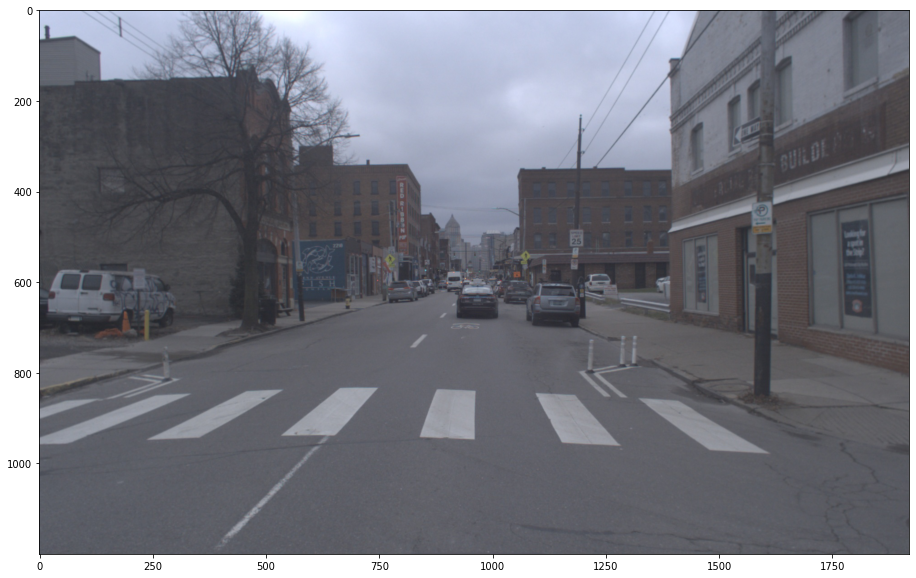

In [63]:
camera = 'ring_front_center'
img = argoverse_data.get_image_sync(idx,camera = camera)
plt.figure(figsize=(20, 10))
plt.imshow(img)

Similarly, we can also plot map info on top of lidar point clouds.

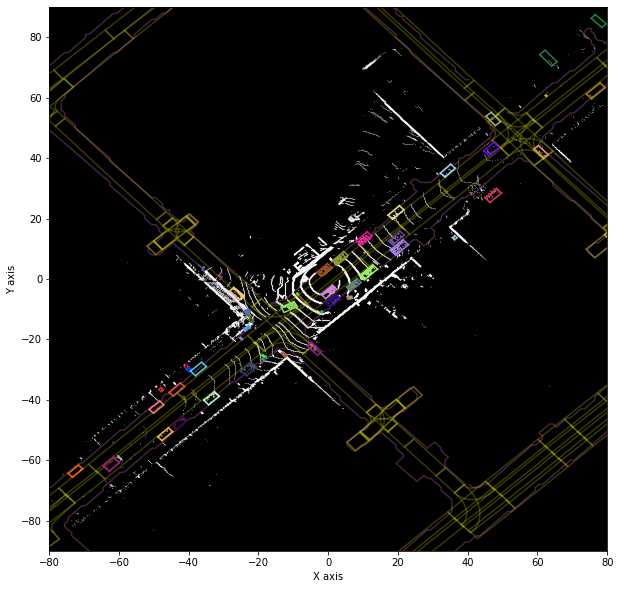

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

xcenter,ycenter,_ = argoverse_data.get_pose(idx).translation
    
xmin = xcenter - 80  # 150
xmax = xcenter + 80  # 150
ymin = ycenter - 80  # 150
ymax = ycenter + 80  # 150

ax.scatter(xcenter, ycenter, 200, color="g", marker=".", zorder=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
domv.render_bev_labels_mpl(
    city_name,
    ax,
    "ego_axis",
    lidar_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
)

## Removing points

In many cases, we are only intersted in points that belong to the objects of interest (e.g. cars on the road).

We can filter out any points that lie outside of the driveable area, by simply using `ArgoverseMap.remove_non_driveable_area_points`

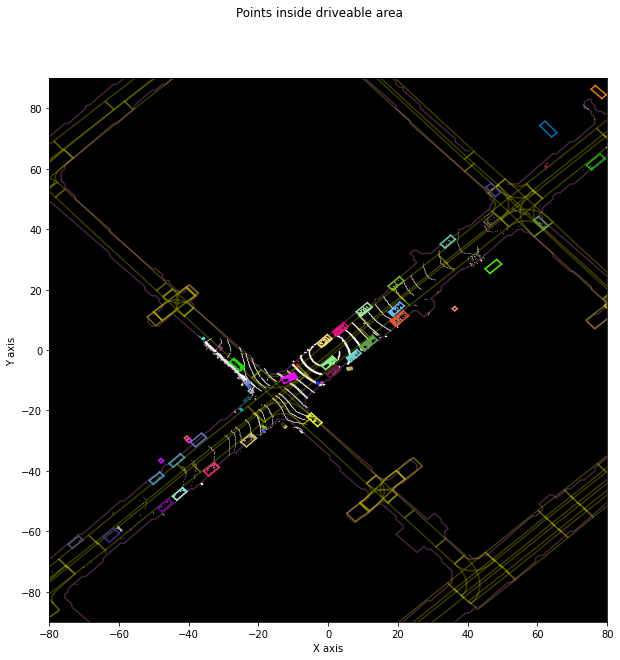

In [9]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Points inside driveable area')
ax = fig.add_subplot(111)

driveable_area_pts = copy.deepcopy(lidar_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

domv.render_bev_labels_mpl(
    city_name,
    ax,
    "ego_axis",
    driveable_area_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
)


Additionally, we can remove points that belong to the ground surface by using `Argoverse.remove_ground_surface`.

This leaves us with points that belong to objects inside the driveable area, which are shown as colored points.

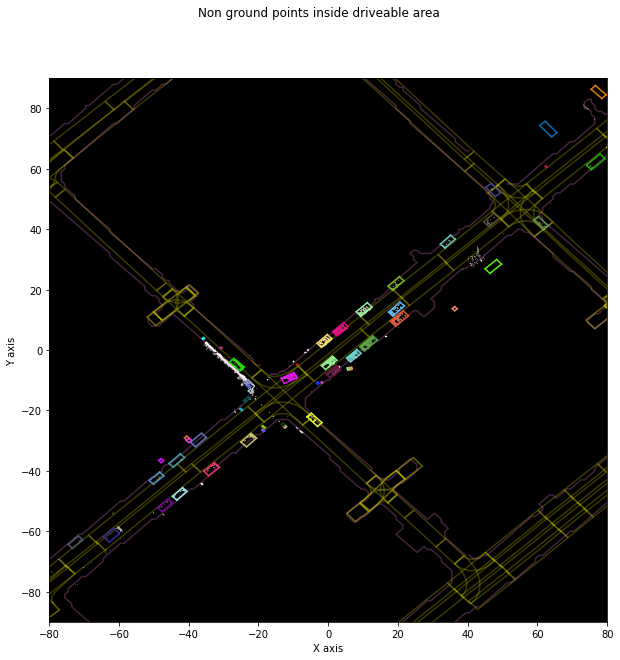

In [10]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Non ground points inside driveable area')
ax = fig.add_subplot(111)

driveable_area_pts = copy.deepcopy(lidar_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
driveable_area_pts = am.remove_ground_surface(driveable_area_pts, city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

domv.render_bev_labels_mpl(
    city_name,
    ax,
    "ego_axis",
    driveable_area_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
)

We can also overlay them on images from our camera sensors.

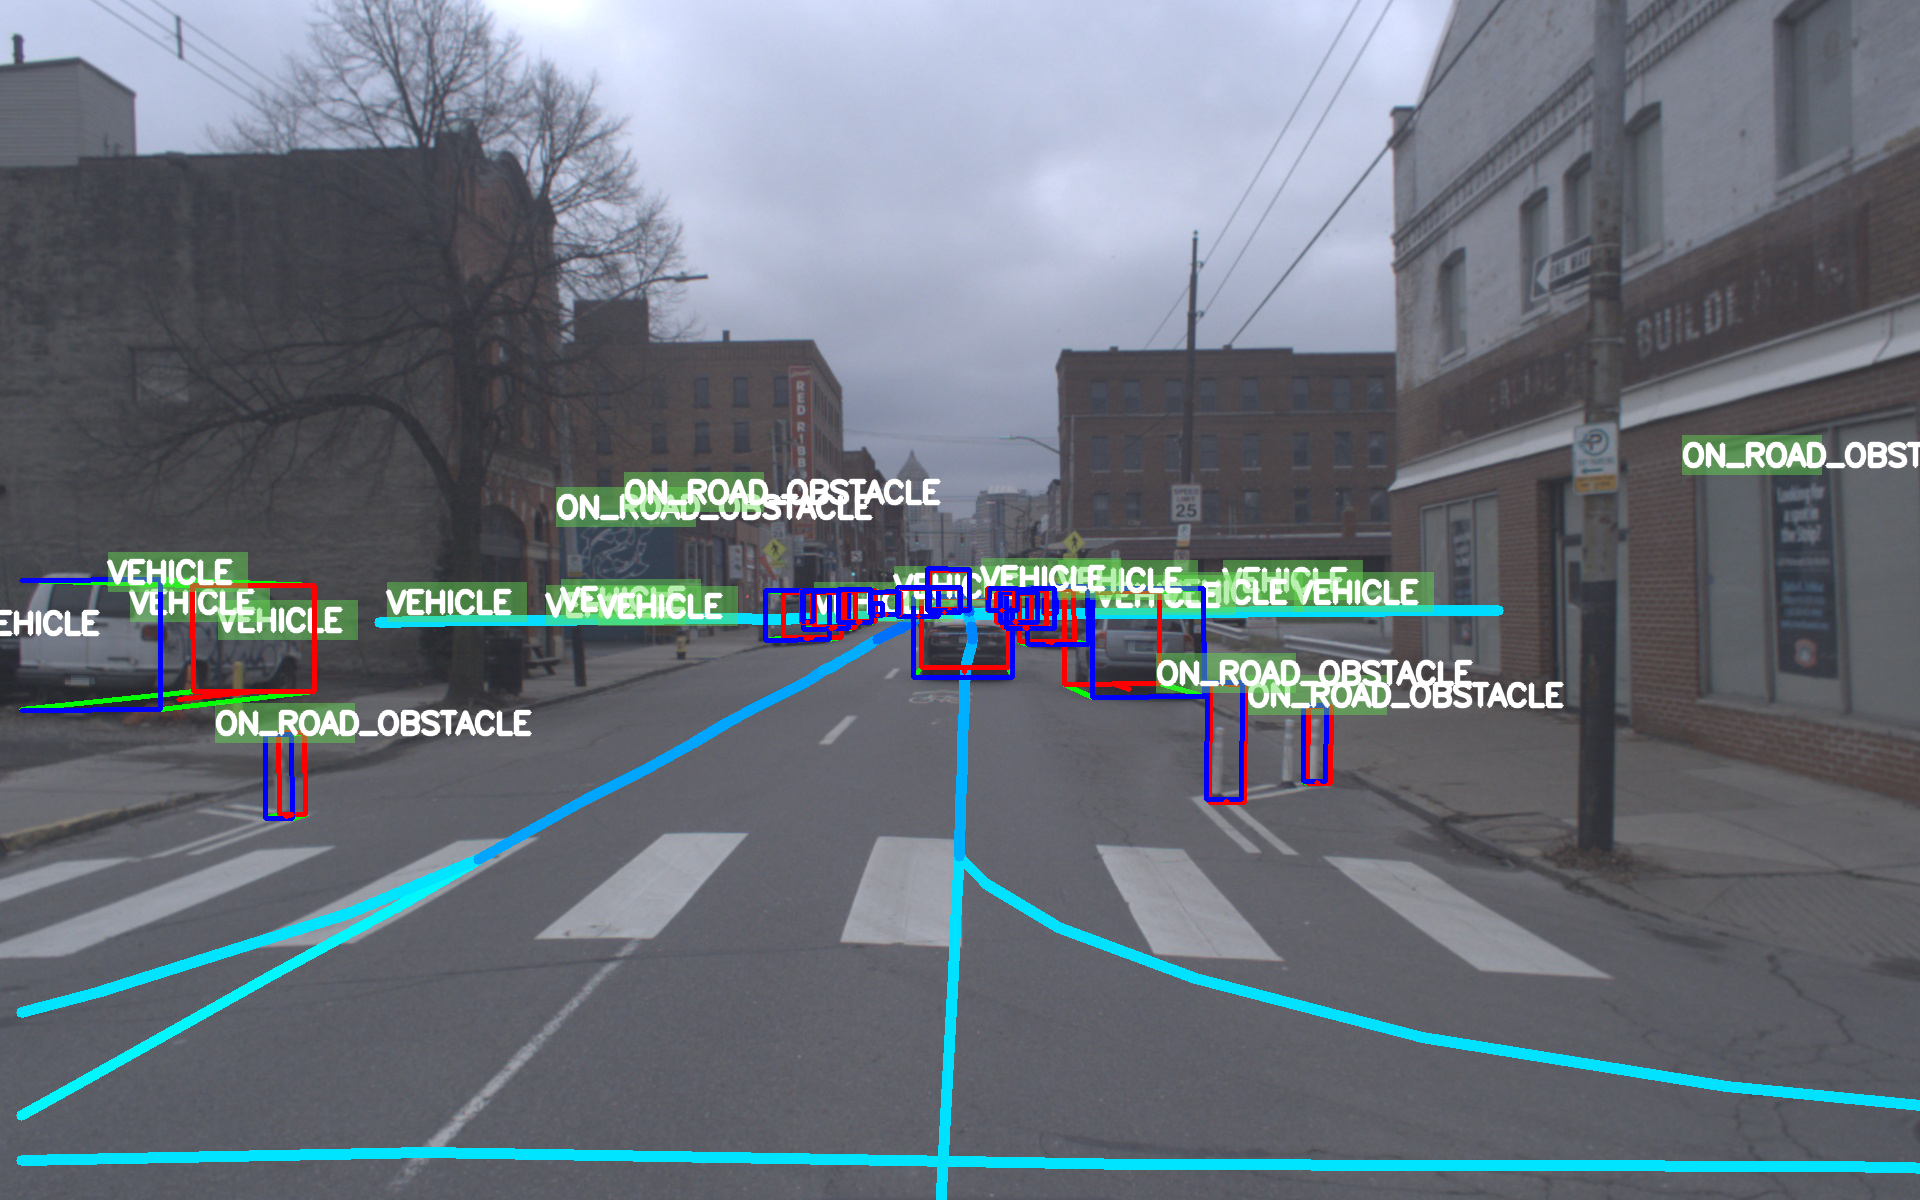

In [64]:
import argoverse.visualization.visualization_utils as viz_util
from argoverse.utils.frustum_clipping import generate_frustum_planes
from PIL import Image 
from cuboids_to_bboxes import plot_lane_centerlines_in_img
camera = 'ring_front_center'

img = argoverse_data.get_image_sync(idx,camera = camera)
objects = argoverse_data.get_label_object(idx)
calib = argoverse_data.get_calibration(camera)

lidar_pts = argoverse_data.get_lidar(idx)
calib = argoverse_data.get_calibration(camera=camera)
planes = generate_frustum_planes(calib.camera_config.intrinsic.copy(), camera)

img_wlane = plot_lane_centerlines_in_img(lidar_pts, city_to_egovehicle_se3, img, city_name, am, calib.camera_config, planes)
#display(Image.fromarray(img_wlane))
img_vis = viz_util.show_image_with_boxes(img_wlane,objects,calib)
display(Image.fromarray(img_vis))

 --------------------------------------------------------------------------------
 ------------------------- Projecting only ground points in driveable area-------
 --------------------------------------------------------------------------------



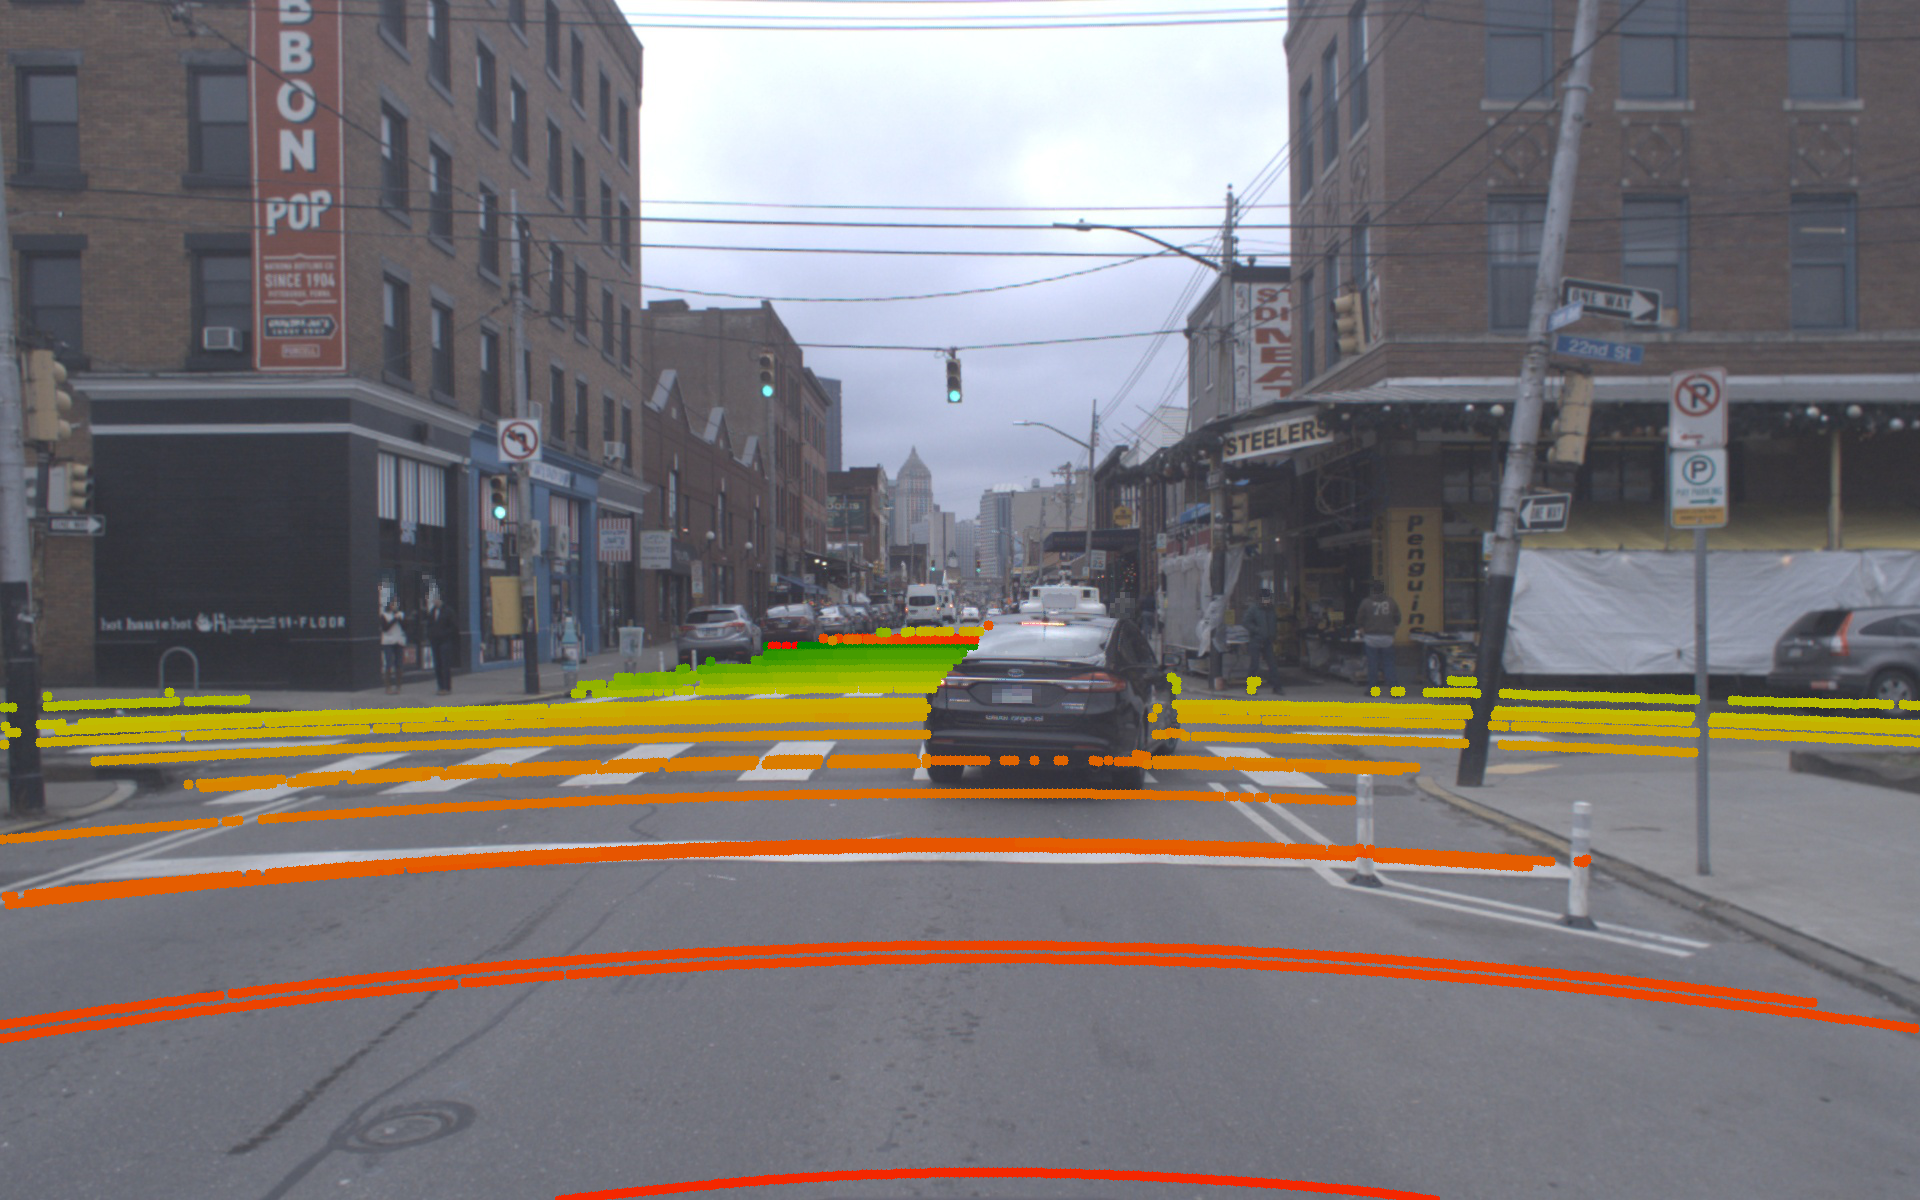

In [12]:
# Using a map to classify LiDAR as ground/non-ground
from argoverse.visualization.ground_visualization import draw_ground_pts_in_image
print(' --------------------------------------------------------------------------------')
print(' ------------------------- Projecting only ground points in driveable area-------')
print(' --------------------------------------------------------------------------------\n')

img = draw_ground_pts_in_image(
            argoverse_data.sync,
            lidar_pts,
            city_to_egovehicle_se3,
            am,
            log_id,
            argoverse_data.lidar_timestamp_list[idx],
            city_name,
            dataset_dir,
            experiment_prefix,
            camera = 'ring_front_center'
        )

display(Image.fromarray(img))